# Sentinel-1 SAR Data Retrieval with Sentinel Hub

This notebook demonstrates how to retrieve Sentinel-1 SAR (Synthetic Aperture Radar) data using the Sentinel Hub API. The data is downloaded based on a specified area of interest (AOI) defined in a GeoJSON file.

TODO: checkout https://sentinelhub-py.readthedocs.io/en/latest/examples/batch_processing.html for downloading SAR data over a large area

### Install dependencies


In [1]:
%pip install geopandas sentinelhub python-dotenv matplotlib numpy shapely -q

Note: you may need to restart the kernel to use updated packages.


### Import Necessary Libraries

In [2]:
# Import necessary libraries

import geopandas as gpd
from sentinelhub import (
    SentinelHubDownloadClient,
    CRS,
    BBox,
    DataCollection,
    MimeType,
    BBoxSplitter,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import numpy as np

/home/aryaniyaps/web-projects/sentinel-1-sar-extraction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Environment Variables

In [3]:
load_dotenv()

True

### Load Sentinel Hub Credentials

In this step, we configure the Sentinel Hub API credentials needed to authenticate requests.


In [4]:
# Load your Sentinel Hub credentials
config = SHConfig(
    sh_base_url="https://sh.dataspace.copernicus.eu",
    sh_token_url="https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
    sh_client_id=os.getenv("sentinel_hub_client_id"),
    sh_client_secret=os.getenv("sentinel_hub_client_secret"),
)

### Load the GeoJSON Area of Interest (AOI)

Here, we load the AOI from a GeoJSON file and extract its boundaries.


In [5]:
# Load the GeoJSON area of interest (AOI)
aoi = gpd.read_file("extraction_areas/mumbai_offshore.geojson")

# Convert the AOI to a bounding box (min_x, min_y, max_x, max_y format)
min_x, min_y, max_x, max_y = aoi.total_bounds
bbox = BBox(bbox=[min_x, min_y, max_x, max_y], crs=CRS.WGS84)  # type:ignore[arg-type]

# Convert the AOI to a bounding box (min_x, min_y, max_x, max_y format)
min_x, min_y, max_x, max_y = aoi.total_bounds
bbox = BBox(bbox=[min_x, min_y, max_x, max_y], crs=CRS.WGS84)  # type:ignore[arg-type]

# Define the number of splits in x and y direction
n_splits = 5

# Split the bounding box using BBoxSplitter
splitter = BBoxSplitter([bbox], crs=CRS.WGS84, split_shape=(n_splits, n_splits))

# Get the bounding boxes after splitting
bbox_list = splitter.get_bbox_list()

# If needed, you can print or visualize the bounding boxes
print(f"{len(bbox_list)} images created")


25 images created


### Visualize Bounding Box Splits

/tmp/ipykernel_9009/1742092339.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


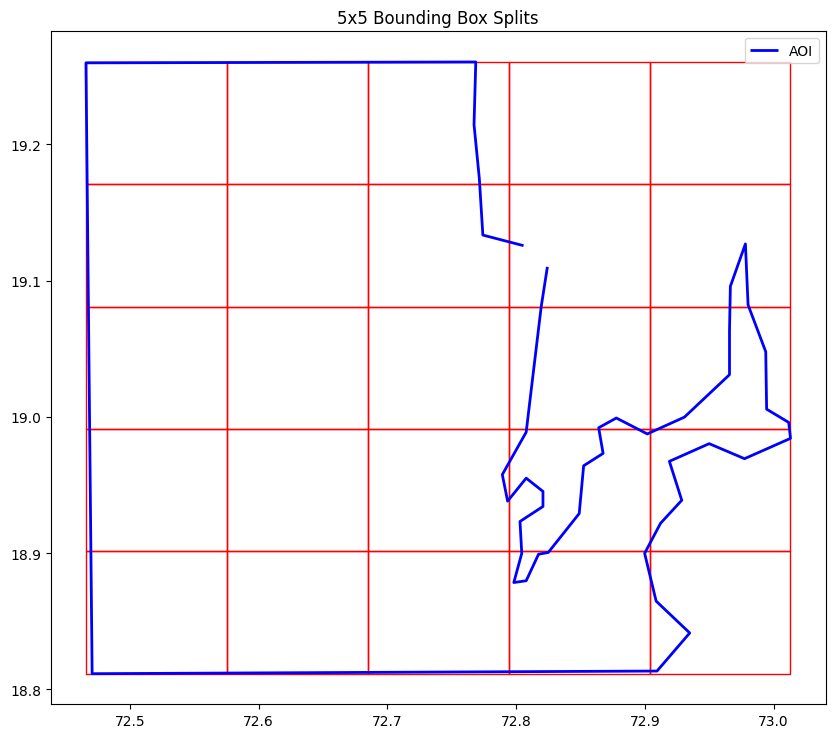

In [6]:
from shapely.geometry import box

# Create a list of shapely boxes (rectangles) for visualization
split_polygons = [box(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y) for bbox in bbox_list]

# Convert the list of polygons to a GeoDataFrame for easier plotting
split_gdf = gpd.GeoDataFrame(geometry=split_polygons, crs=CRS.WGS84.pyproj_crs())

# Plot the original AOI and the split bounding boxes
fig, ax = plt.subplots(figsize=(10, 10))
aoi.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=2, label="AOI")
split_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, label="Splits")
plt.title(f"{n_splits}x{n_splits} Bounding Box Splits")
plt.legend()
plt.show()

### Check Bounding Box Dimensions

In this step, we check the size of an individual bounding box area in pixels based on the desired resolution.


In [7]:
resolution = 5
# Define the size of the bounding box area (in pixels)
bbox_size = bbox_to_dimensions(bbox_list[1], resolution=resolution)  # Adjust resolution as needed
print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")

Image shape at 5 m resolution: (2334, 1957) pixels


### Create Sentinel Hub Requests for SAR Data

Here, we configure the request for Sentinel-1 SAR data with the specified evaluation script.

In [8]:
from datetime import datetime, timedelta

start_date = datetime(2018, 9, 5)
end_date = datetime(2018, 12, 31)
delta = timedelta(days=12)  # Sentinel-1 Repeat cycle is 12 days

In [9]:
all_requests = []

for bbox in bbox_list:
  current_date = start_date
  while current_date <= end_date:
      request = SentinelHubRequest(
          data_folder="./downloads",
          evalscript="""
          //VERSION=3
          function setup() {
            return {
              input: ["VV"],
              output: { bands: 1 }
            };
          }

          function evaluatePixel(sample) {
            return [sample.VV];
          }
          """,
          input_data=[
              SentinelHubRequest.input_data(
                  data_collection=DataCollection.SENTINEL1_IW.define_from(
                      "s1iw", service_url=config.sh_base_url
                  ),
                  time_interval=(
                    current_date.strftime('%Y-%m-%d'), 
                    (current_date + timedelta(days=7)).strftime('%Y-%m-%d') # add buffer time of 7 days
                  ),
              )
          ],
          bbox=bbox,
          size=bbox_to_dimensions(bbox, resolution=resolution),
          responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
          config=config,
      )
      all_requests.append((request, current_date))
      
      current_date += delta  # Move to the next date


### Download SAR Data (Batched)

In [10]:
data = SentinelHubDownloadClient(config=config).download([request.download_list[0] for (request, current_date) in all_requests], max_threads=5, show_progress=True)

 48%|████▊     | 119/250 [01:07<01:34,  1.38it/s]/home/aryaniyaps/web-projects/sentinel-1-sar-extraction/.venv/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
 48%|████▊     | 120/250 [01:08<01:30,  1.43it/s]/home/aryaniyaps/web-projects/sentinel-1-sar-extraction/.venv/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/aryaniyaps/web-projects/sentinel-1-sar-extraction/.venv/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
 48%|████▊     | 121/250 [01:09<01:40,  1.29it/s]/home/aryaniyaps/web-projects/sentinel-1-sar-extraction/.venv/lib/python3.12/site-packages/

### Visualize Downloaded Data

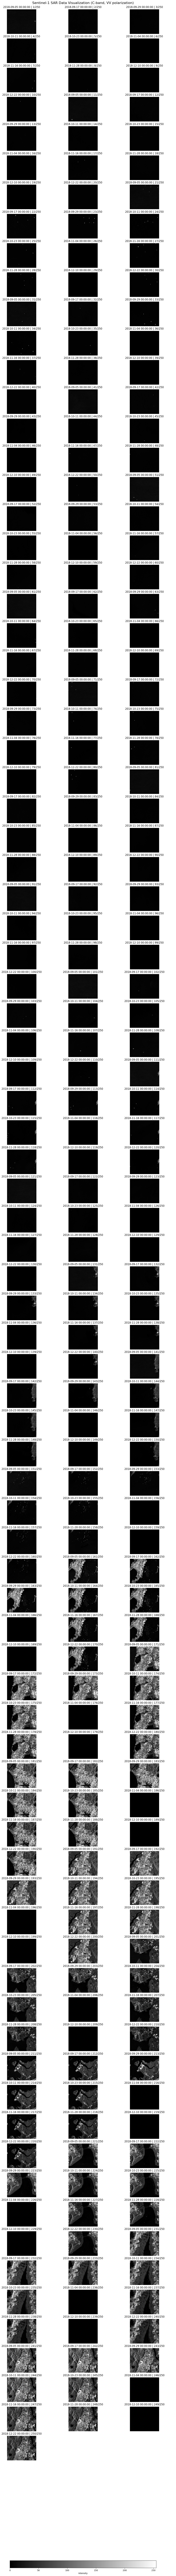

In [11]:
# Assuming data contains the images retrieved
num_images = len(data)  # Number of images from requests

# Define number of columns for the subplot
num_cols = 3  # Set the number of columns
num_rows = int(np.ceil(num_images / num_cols))  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 2), constrained_layout=True)  # Use constrained layout

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i in range(num_images):
    axes[i].imshow(data[i], cmap='gray', vmin=0, vmax=255)
    axes[i].set_title(f'{all_requests[i][1]} | {i + 1}/{num_images}')  # Title for each subplot
    axes[i].axis('off')  # Turn off the axis

# Turn off any unused subplots
for j in range(num_images, len(axes)):
    axes[j].axis('off')  # Hide unused subplots

# Create a shared colorbar
# Adjusting the size and location of the colorbar
cbar = plt.colorbar(axes[0].images[0], ax=axes, orientation='horizontal', fraction=0.02, pad=0.04, shrink=0.8)
cbar.set_label('Intensity')

# Set the main title
plt.suptitle('Sentinel-1 SAR Data Visualization (C-band, VV polarization)', fontsize=16)

# Use tight layout to ensure no overlap
plt.show()